# Home Assignment No. 3

To solve this task, you will write a lot of code to try several machine learning methods for classification and regression.
* You are **HIGHLY RECOMMENDED** to read relevant documentation, e.g. for [python](https://docs.python.org/3/), [numpy](https://docs.scipy.org/doc/numpy/reference/), [matlpotlib](https://matplotlib.org/) and [sklearn](https://scikit-learn.org/stable/). Also remember that seminars, lecture slides, [Google](http://google.com) and [StackOverflow](https://stackoverflow.com/) are your close friends during this course (and, probably, whole life?).

* If you want an easy life, you have to use **BUILT-IN METHODS** of `sklearn` library instead of writing tons of your own code. There exists a class/method for almost everything you can imagine (related to this homework).

* You have to write **CODE** directly inside specified places marked by comments: **BEGIN/END Solution**. Do not create new cells.

* In some problems you are asked to provide a short discussion of the results. For that find the specific place marked via **Your text answer: \<write your answer\>**.

* For every separate problem or subproblem (if specified) you can get only 0 points or maximal points for this problem. There are **NO INTERMEDIATE scores**. So make sure that you did everything required in the task.

* Your **SOLUTION** notebook **MUST BE REPRODUCIBLE**, i.e., if the reviewer decides to restart the notebook and run all cells, after all the computation he will obtain exactly the same solution (with all the corresponding plots) as in your uploaded notebook. For this purpose, we suggest fixing random `seed` or (better) define `random_state=` inside every algorithm that uses some pseudorandomness.

* Your code must be clear to the reviewer. For this purpose, try to include necessary comments inside the code. But remember: **GOOD CODE MUST BE SELF-EXPLANATORY** without any additional comments.

* Many `sklearn` algorithms support multithreading (Ensemble Methods, Cross-Validation, etc.). Check if the particular algorithm has `n_jobs` parameters and set it to `-1` to use all the cores.


In [25]:
# Your imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import GPy

from tqdm import tqdm, tqdm_notebook
from sklearn.metrics import r2_score
from sklearn.neighbors import NearestNeighbors

from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score

from sklearn.cluster import Birch, AgglomerativeClustering
from sklearn.model_selection import StratifiedKFold, RepeatedKFold
import scipy

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
import warnings
warnings.filterwarnings("ignore")
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier



## Task 1 - Gaussian Processes (1 pt.)

In the following exercise, you will need to fit the gaussian process with different kernels on the ```elecricity_consumption_FR.csv``` time series data. We have already loaded and prepared the train/test datasets for you below.

Use [**GPy**](https://pypi.python.org/pypi/GPy) library for training and prediction. Fit a GP and run the predict on the test. Useful kernels to combine: `GPy.kern.RBF, GPy.kern.Poly, GPy.kern.StdPeriodic, GPy.kern.White, GPy.kern.Linear`. 

**The task**:
* Normalize the target value by fitting a transformation on the train (use ```sklearn.preprocessing.StandardScaler```)
* Plot the resulting target against the time index.
* Plot mean and confidence interval of the prediction. 
* Inspect them on normality by scatter plot: plot predicted points/time series against true values. 
* Estimate the prediction error with `r2_score`. R2-score accepted > 0.7 on test sample.

In [26]:
! pip install GPy==1.9.9

In [27]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

In [28]:
data = pd.read_csv('elecricity_consumption_FR.csv')

In [29]:
data.dropna(inplace=True)

In [30]:
y = np.array(data.values)
X = np.array(data.index)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.3)
X_train = X_train.reshape(-1,1)
X_test = X_test.reshape(-1,1)


Normalize the target value by fitting a transformation on the train (use sklearn.preprocessing.StandardScaler)

In [32]:
### BEGIN SOLUTION (do not delete this comment!)
scaler = StandardScaler()
scaler.fit(y_train)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)
### END SOLUTION (do not delete this comment!)

Plot the resulting target against the time index.

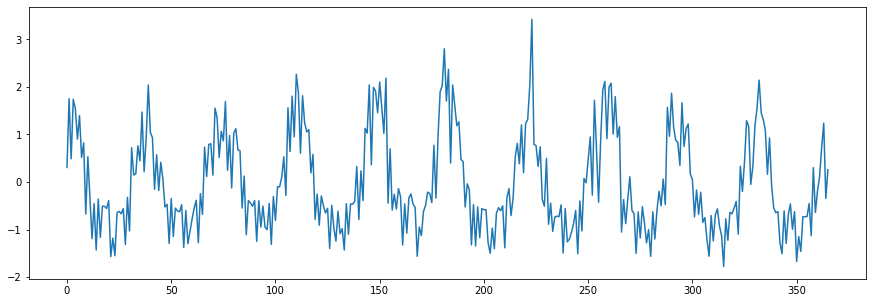

In [33]:
### BEGIN SOLUTION (do not delete this comment!)

plt.figure(figsize=(15, 5))
plt.plot(X, np.concatenate((y_train,y_test), axis=0))
    
### END SOLUTION (do not delete this comment!)

Plot mean and confidence interval of the prediction.

{'dataplot': [<matplotlib.collections.PathCollection at 0x7ff6c5b41390>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x7ff6c4b4b390>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x7ff6c727a1d0>]}

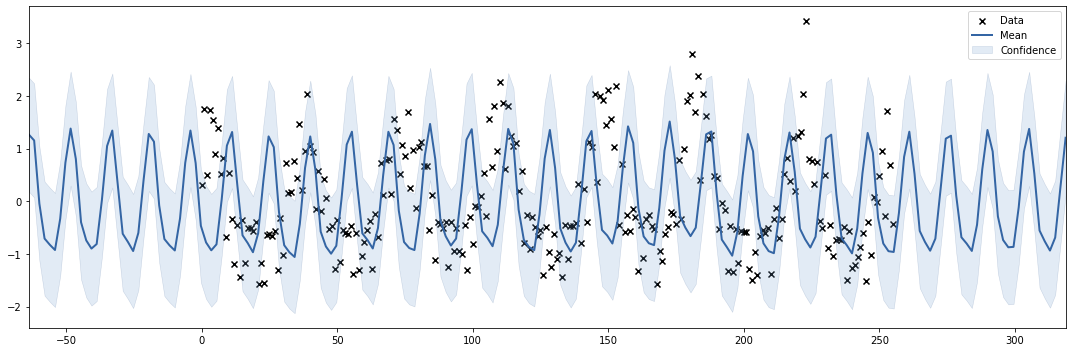

In [34]:
### BEGIN SOLUTION (do not delete this comment!)
k_trend = GPy.kern.StdPeriodic(1) + GPy.kern.RBF(1) + GPy.kern.Poly(1, 1)
k_periodicity = GPy.kern.StdPeriodic(1) * GPy.kern.RBF(1) *  GPy.kern.Linear(1)
kernel = k_trend + k_periodicity
model = GPy.models.GPRegression(X_train, y_train, kernel)
model.optimize()
model.plot(figsize=(15, 5))
### END SOLUTION (do not delete this comment!))

Inspect them on normality by scatter plot: plot predicted points/time series against true values.

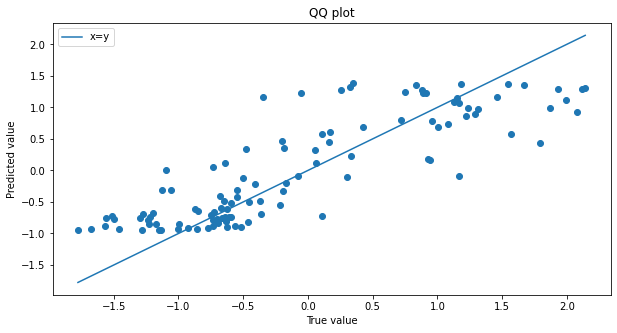

In [35]:
### BEGIN SOLUTION (do not delete this comment!)
plt.figure(figsize=(10, 5))

y_pred = model.predict(X_test)[0]
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], label='x=y')
plt.title('QQ plot')
plt.ylabel('Predicted value')
plt.xlabel('True value')
plt.legend()

### END SOLUTION (do not delete this comment!)

Estimate the prediction error with r2_score. R2-score accepted > 0.7 on test sample.

In [36]:
### BEGIN SOLUTION (do not delete this comment!)
print(f'R2-score: {r2_score(y_test, y_pred)}')
### END SOLUTION (do not delete this comment!)

R2-score: 0.7119913375215381


## Task 2 - MNIST, kMNIST component analysis and manifold learning. (5 pts.)

### Task 2.1. (1 pt)

Download `MNIST` dataset. Here we will estimate the data intrinsic dimensionality, decompose the dataset on principle components and estimate the cumulative explained variance by each component.

You can either use the [proposed method](https://www.stat.berkeley.edu/~bickel/mldim.pdf) for the estimation of sample intrinsic dimension or any other method (convenient for you). For the first case, yoyu may use the code from [here](https://gist.github.com/mehdidc/8a0bb21a31c43b0cbbdd31d75929b5e4)

1. Estimate the intrinsic dimensionality of the dataset. Provide the plot.
2. Decompose the data on principal components (PCA). Plot the cumulative explained variance by each component. Plot the example of back-decomposition with **6** different set of components and corresponding explained variance. You can choose any digit from the dataset.

In [374]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

dg = datasets.load_digits()

scaler = StandardScaler().fit(dg.data)
data = scaler.transform(dg.data)

1) Estimate the intrinsic dimentionality of the dataset. Provide the plot.

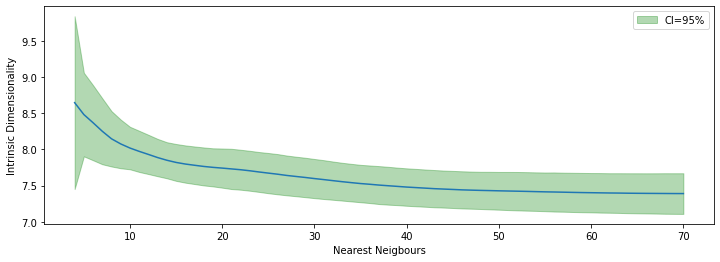

In [377]:
### BEGIN SOLUTION (do not delete this comment!)
#implementation from: https://gist.github.com/mehdidc/8a0bb21a31c43b0cbbdd31d75929b5e4

def intrinsic_dim_sample_wise(X, k=5):
    neighb = NearestNeighbors(n_neighbors=k + 1).fit(X)
    dist, ind = neighb.kneighbors(X)
    dist = dist[:, 1:]
    dist = dist[:, 0:k]
    assert dist.shape == (X.shape[0], k)
    assert np.all(dist > 0)
    d = np.log(dist[:, k - 1: k] / dist[:, 0:k-1])
    d = d.sum(axis=1) / (k - 2)
    d = 1. / d
    intdim_sample = d
    return intdim_sample

def intrinsic_dim_scale_interval(X, k1=10, k2=20):
    X = pd.DataFrame(X).drop_duplicates().values # remove duplicates in case you use bootstrapping
    intdim_k = []
    for k in range(k1, k2 + 1):
        m = intrinsic_dim_sample_wise(X, k).mean()
        intdim_k.append(m)
    return intdim_k

def repeated(func, X, nb_iter=100, random_state=None, verbose=0, mode='bootstrap', **func_kw):
    if random_state is None:
        rng = np.random
    else:
        rng = np.random.RandomState(random_state)
    nb_examples = X.shape[0]
    results = []

    iters = range(nb_iter)
    if verbose > 0:
        iters = tqdm_notebook(iters)    
    for i in iters:
        if mode == 'bootstrap':
            Xr = X[rng.randint(0, nb_examples, size=nb_examples)]
        elif mode == 'shuffle':
            ind = np.arange(nb_examples)
            rng.shuffle(ind)
            Xr = X[ind]
        elif mode == 'same':
            Xr = X
        else:
            raise ValueError('unknown mode : {}'.format(mode))
        results.append(func(Xr, **func_kw))
    return results

k1 = 4 # start of interval(included)
k2 = 70 # end of interval(included)
intdim_k_repeated = repeated(intrinsic_dim_scale_interval, 
                             data, 
                             mode='bootstrap', 
                             nb_iter=200, # nb_iter for bootstrapping
                             verbose=1, 
                             random_state=42,
                             k1=k1, k2=k2)
intdim_k_repeated = np.array(intdim_k_repeated)

plt.figure(figsize=(12, 4))
interval = np.arange(k1, k2+1)
k_mean = intdim_k_repeated.mean(0)
# k_max = np.quantile(intdim_k_repeated, .95, axis=0)
# k_min = np.quantile(intdim_k_repeated, .05, axis=0)
plt.plot(interval, k_mean)
plt.fill_between(interval, 
                 np.mean(intdim_k_repeated, axis=0) - 
                 2 * np.std(intdim_k_repeated, axis=0),
                 np.mean(intdim_k_repeated, axis=0) + 
                 2 * np.std(intdim_k_repeated, axis=0),
                 alpha=0.3,
                 label='CI=95%',
                 color='g')

plt.xlabel('Nearest Neigbours')
plt.ylabel('Intrinsic Dimensionality')
plt.legend()
plt.show()

### END SOLUTION (do not delete this comment!)

2) Decompose the data on principal components (PCA). Plot the cumulative explained variance by each component. Plot the example of back-decomposition with 6 different set of components and corresponding explained variance. You can choose any digit from the dataset.

Text(0.5, 0, '# principle components')

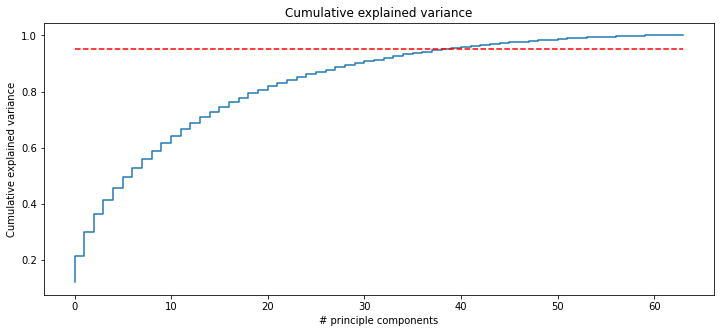

In [216]:
plt.figure(figsize=(12, 5))
pca = PCA().fit(data)
plt.step(np.arange(data.shape[1]), np.cumsum(pca.explained_variance_ratio_), label='cumulative explained variance')
plt.plot(np.arange(data.shape[1]), np.full(data.shape[1], 0.95), '--', c='red', label='95% explained variance')
plt.title('Cumulative explained variance')
plt.ylabel('Cumulative explained variance')
plt.xlabel('# principle components')

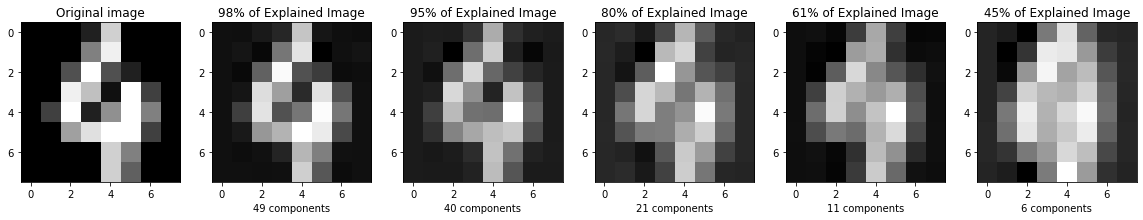

In [278]:
### BEGIN SOLUTION (do not delete this comment!)

fig, axs = plt.subplots(1, 6, figsize=(20, 10))
percents = [.98, .95, .80, .61, .45]

axs[0].imshow(scaler.inverse_transform(data[100][None]).reshape(8, 8), cmap='gray')
axs[0].set_title('Original image')

for percent, ax in zip(percents, axs[1:].ravel()):
    pca = PCA(percent)
    low_data = pca.fit_transform(data)
    rec_data = pca.inverse_transform(low_data)
    ax.imshow(scaler.inverse_transform(rec_data[100][None]).reshape(8, 8), cmap='gray')
    ax.set_title(f'{int(percent*100)}% of Explained Image')
    ax.set_xlabel(f'{pca.n_components_} components')


### END SOLUTION (do not delete this comment!)


### Task 2.2. (1 pt.)

Here we will visualize the decomposition in order to observe how data diverges across different manifold learning methods. We are to compare `PCA`, `ICA` and `Isomap` non-linear decompositions [see more over here https://scikit-learn.org/stable/modules/manifold.html], and check the classification accuracy on the new features. 

1. Calculate new features on the data with ICA, PCA and Isomap. **Choose the number of components according to your estimation of intrinsic dimension**. Calculate the classification accuracy on these features with `LogisticRegression` on `cross_val=5` with $3$ repeats. Use `RepeatedKFold` and fit the `random_seed = 42`.
2. Show that the `Isomap` gives a statistically significant improvement on the classification accuracy with any appropriate statistical test. Provide corresponding `p-values`. Justify your results, write down 2-3 sentences.


In [3]:
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from scipy import stats
from sklearn.decomposition import PCA, FastICA
from sklearn.manifold import Isomap

1) Calculate new features on the data with ICA, PCA and Isomap. Choose the number of components according to your estimation of intrinsic dimention. Calculate the classification accuracy on these features with LogisticRegression on cross_val=5 with  3  repeats. Use RepeatedKFold and fit the random_seed = 42.

In [391]:
### BEGIN SOLUTION (do not delete this comment!)
rnd_seed = 42
n_comp = 8
features = {}
all_scores = []
methods = {'PCA': PCA(n_components=n_comp),
           'FastICA': FastICA(n_components=n_comp, random_state=rnd_seed),
           'Isomap': Isomap(n_components=n_comp)}

for k in methods.keys():
    print(f'{methods[k]} fit_transform...')
    data_transf = methods[k].fit_transform(data)
    features[k] = data_transf
    
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=rnd_seed)
print('\nLogisticRegression scores')
for k in methods.keys():
    clf = LogisticRegression()
    scores = cross_val_score(clf, features[k], dg.target, scoring='accuracy', cv=cv, n_jobs=-1)
    all_scores.append(scores)
    print(k, np.mean(scores))
### END SOLUTION (do not delete this comment!)

PCA(n_components=8) fit_transform...
FastICA(n_components=8, random_state=42) fit_transform...
Isomap(n_components=8) fit_transform...

LogisticRegression scores
PCA 0.8729376869906119
FastICA 0.7150943980191891
Isomap 0.9530625193438564


2) Show that the `Isomap` gives statistically significant improvement on the classification accuracy with any appropriate statistical test. Provide corresponding `p-values`. 

In [384]:
### BEGIN SOLUTION (do not delete this comment!)
stat, p_value = stats.ttest_ind(all_scores[-1], all_scores[0])
print( f'T test with alternative hypothesis that Isomap has greater accuracy than PCA')
print(f'Statistic: {stat} p_value: {p_value}' )
print()
stat, p_value = stats.ttest_ind(all_scores[-1], all_scores[1])
print( f'T test with alternative hypothesis that Isomap has greater accuracy than FastICA')
print(f'Statistic: {stat} p_value: {p_value} ')


### END SOLUTION (do not delete this comment!)

T test with alternative hypothesis that Isomap has greater accuracy than PCA
Statistic: 13.296253431985091 p_value: 1.2765086009759228e-13

T test with alternative hypothesis that Isomap has greater accuracy than FastICA
Statistic: 22.659502395996043 p_value: 1.4982673421427805e-19 


### Task 2.3. (1 pt.)

3) Justify your results, write down 2-3 senteces.

*BEGIN SOLUTION (do not delete this comment!)*

PCA method tries to find a good linear projection of the data, FastICA is linear as well. So, here Isomap outperforms this two methods because it is non-linear and the image data is quite complex for linear approximations. However, if we increase number of components then other methods can also achieve high accuracy .90+ but we will have to store more data what is not that impressive.

*END SOLUTION (do not delete this comment!)*

### Task 2.4. kMNIST dimensionality reduction. (2 pts.)

Explore `KMNIST` dataset https://github.com/rois-codh/kmnist. You are to engineer new features (by using any familiar to you method of Manifold Learning) to increase the classification accuracy. Use the `KNN` classifier with any hyperparameters you like.

1. __(2 pt.)__ Get accuracy on `test_set` more than 93%`. 

**NOTE** that the data is rather heavy, thus your decomposition will take a while.

__Hint:__ Try to use dimensionality reduction methods, which yield better model performance on `MNIST`. These methods can compete with Autoencoders on `torch`. 

1) Get accuracy on test_set more than 93%.

In [4]:
import numpy as np

In [5]:
from sklearn.neighbors import KNeighborsClassifier

def load(f):
    return np.load(f)['arr_0']

# Load the data
x_train = load('kmnist-train-imgs.npz')
x_test = load('kmnist-test-imgs.npz')
y_train = load('kmnist-train-labels.npz')
y_test = load('kmnist-test-labels.npz')

# Reshape the data
x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

In [24]:
dim_reduction = PCA(0.8)
dim_reduction.fit(np.concatenate((x_train, x_test)))

x_train_tf = dim_reduction.transform(x_train)
x_test_tf = dim_reduction.transform(x_test)

In [28]:
clf = KNeighborsClassifier(n_neighbors=4)
clf.fit(x_train_tf, y_train)
y_pred = clf.predict(x_test_tf)
print(f'Test accuracy: {accuracy_score(y_test, y_pred)}')

Test accuracy: 0.932


## Task 3 - Clustering (2 pts.)

### Task 3.1. Explore KMeans and Gaussian Mixture algorithms (1 pt.)

Try **KMeans, Gaussian Mixture** and **two** more clustering algorithms from sklearn. 
To evaluate clustering performance use **two** clustering metrics: *silhouette score*
and *mutual information* or *adjusted mutual information*.

For each algorithm **your task** is to try to find the parameters leading to the best performance for `n_clusters=true_number_of_clusters`:
1. Apply the algorithm with the true number of clusters and try out at least two **other variants** of the number of clusters: a smaller and a larger one than the true number.;
2. For each number of clusters **visualize the clustering result**, calculate the **clustering metrics** and plot them;

__NOTE:__ `sklearn.model_selection.GridSearchCV` does not support clustering methods, thus you suppose to do it manually.

In [2]:
import numpy as np

True number of clusters is 15


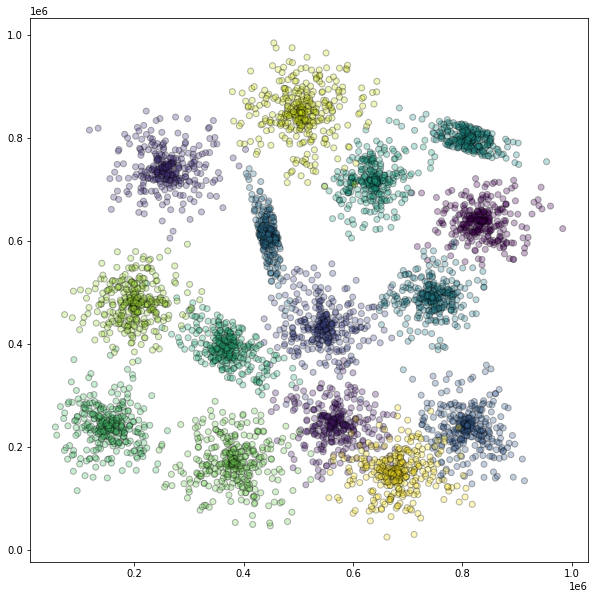

In [3]:
points, labels = np.loadtxt('clustering.txt'), np.loadtxt('clustering_labels.txt')
labels = labels.astype(int)
print("True number of clusters is {}".format(np.max(labels)))
plt.figure(figsize=(10, 10))
plt.scatter(points[:,0], points[:,1], c=labels, alpha=0.3, edgecolor='k')

plt.show()

In [4]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, mutual_info_score
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler

1) For each algorithm your task is to try to find the parameters leading to the best performance for n_clusters=true_number_of_clusters

In [20]:
### BEGIN SOLUTION (do not delete this comment!)
rnd_state = 42

def gridsearchcv_clust(name, method, param_grid, data, cv=5, verbose=0):
    X, y = data
    best_score = 0
    best_params = None
    skf = StratifiedKFold(n_splits=cv)
    
    scores_silhouette = []
    scores_mutualinfo = []
    for params in ParameterGrid(param_grid):
        if verbose:
            print(f'{name} with {params}')
        
        if name == 'AgglomerativeClustering' and params['linkage'] == 'ward' and params['affinity'] != 'euclidean':
            print(f'Ward works only with Euclidean affinity so skippint affinity=', params['affinity'])
            continue
            
        clf = method(**params)
        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            if name == 'AgglomerativeClustering':
                y_pred = clf.fit_predict(X_test)
            else:
                clf.fit(X_train)
                y_pred = clf.predict(X_test)
            scores_silhouette.append(silhouette_score(X_test, y_pred))
            scores_mutualinfo.append(mutual_info_score(y_test, y_pred))
        
        if verbose:
            print(f'\tScores silhouette: {np.mean(scores_silhouette):.3}, Scores mutual info: {np.mean(scores_mutualinfo):.3}')
        
        score = np.mean(scores_silhouette)
        if score > best_score:
            best_score = score
            best_params = params
            
        print()   
    return best_params, best_score
            

true_number_of_clusters = np.max(labels)

clust_methods = {'KMeans': {'method': KMeans,
                            'params': {'n_clusters': [true_number_of_clusters],
                                       'init': ['k-means++', 'random'],
                                       'random_state': [rnd_state]}},
                 
                 'GaussianMixture_params': {'method': GaussianMixture,
                                            'params':{'n_components': [true_number_of_clusters], 
                                                      'covariance_type': ['full', 'tied', 'diag', 'spherical'],
                                                      'random_state': [rnd_state]}},
                 
                 'Birch_params':{'method': Birch, 
                                 'params': {'n_clusters': [true_number_of_clusters], 
                                            'threshold': [0.1, 0.3, 0.5, 0.7, 0.9, 1.1], 
                                            'branching_factor': [5, 10, 25, 50, 75]}}, 
                 
                 'AgglomerativeClustering': {'method': AgglomerativeClustering,
                                             'params': {'n_clusters': [true_number_of_clusters], 
                                                        'affinity': ['euclidean', 'l1', 'l2', 'manhattan', 'cosine'],
                                                        'linkage': ['ward', 'complete', 'average', 'single']}}}
bst_clust_methods = dict()

for method_name in clust_methods.keys():   
    # find best parameters for true number of clusters
    params = clust_methods[method_name]['params']
    if params is not None:
        best_params, best_score = gridsearchcv_clust(method_name, clust_methods[method_name]['method'],
                                                     params, data=(points, labels), verbose=1)
        print('='*35)
        print(f'{method_name} best parameters: {best_params} \n \t best score: {best_score:.3}')
        print('='*35)

    else:
        best_params = {}
        
    # add method with best parameters to the dict with other variants of cluster's numbers
    for clust_n in np.arange(10, 20+1, step=1):
        if 'n_components' in best_params:
            best_params['n_components'] = clust_n
        else:
            best_params['n_clusters'] = clust_n
            
        if 'random_state' in clust_methods[method_name]['method']().get_params().keys():
            best_params['random_state'] = rnd_state
            
        bst_clust_methods[f'{method_name}_nclust={clust_n}'] = clust_methods[method_name]['method'](**best_params)


### END SOLUTION (do not delete this comment!)

KMeans with {'init': 'k-means++', 'n_clusters': 15, 'random_state': 42}
	Scores silhouette: 0.625, Scores mutual info: 2.58

KMeans with {'init': 'random', 'n_clusters': 15, 'random_state': 42}
	Scores silhouette: 0.625, Scores mutual info: 2.57

KMeans best parameters: {'init': 'k-means++', 'n_clusters': 15, 'random_state': 42} 
 	 best score: 0.625
GaussianMixture_params with {'covariance_type': 'full', 'n_components': 15, 'random_state': 42}
	Scores silhouette: 0.578, Scores mutual info: 2.51

GaussianMixture_params with {'covariance_type': 'tied', 'n_components': 15, 'random_state': 42}
	Scores silhouette: 0.582, Scores mutual info: 2.5

GaussianMixture_params with {'covariance_type': 'diag', 'n_components': 15, 'random_state': 42}
	Scores silhouette: 0.579, Scores mutual info: 2.5

GaussianMixture_params with {'covariance_type': 'spherical', 'n_components': 15, 'random_state': 42}
	Scores silhouette: 0.575, Scores mutual info: 2.49

GaussianMixture_params best parameters: {'covari

	Scores silhouette: 0.261, Scores mutual info: 1.94

AgglomerativeClustering best parameters: {'affinity': 'euclidean', 'linkage': 'ward', 'n_clusters': 15} 
 	 best score: 0.603


2) Apply the algorithm with the true number of clusters and try out at least two other variants of the number of clusters: a smaller and a larger one than the true number.;

 Do not forget that despite the plot picturing just the KMeans and GuassianMizture, you will need to ADDITIONALLY try put and plot two other clustering methods. 

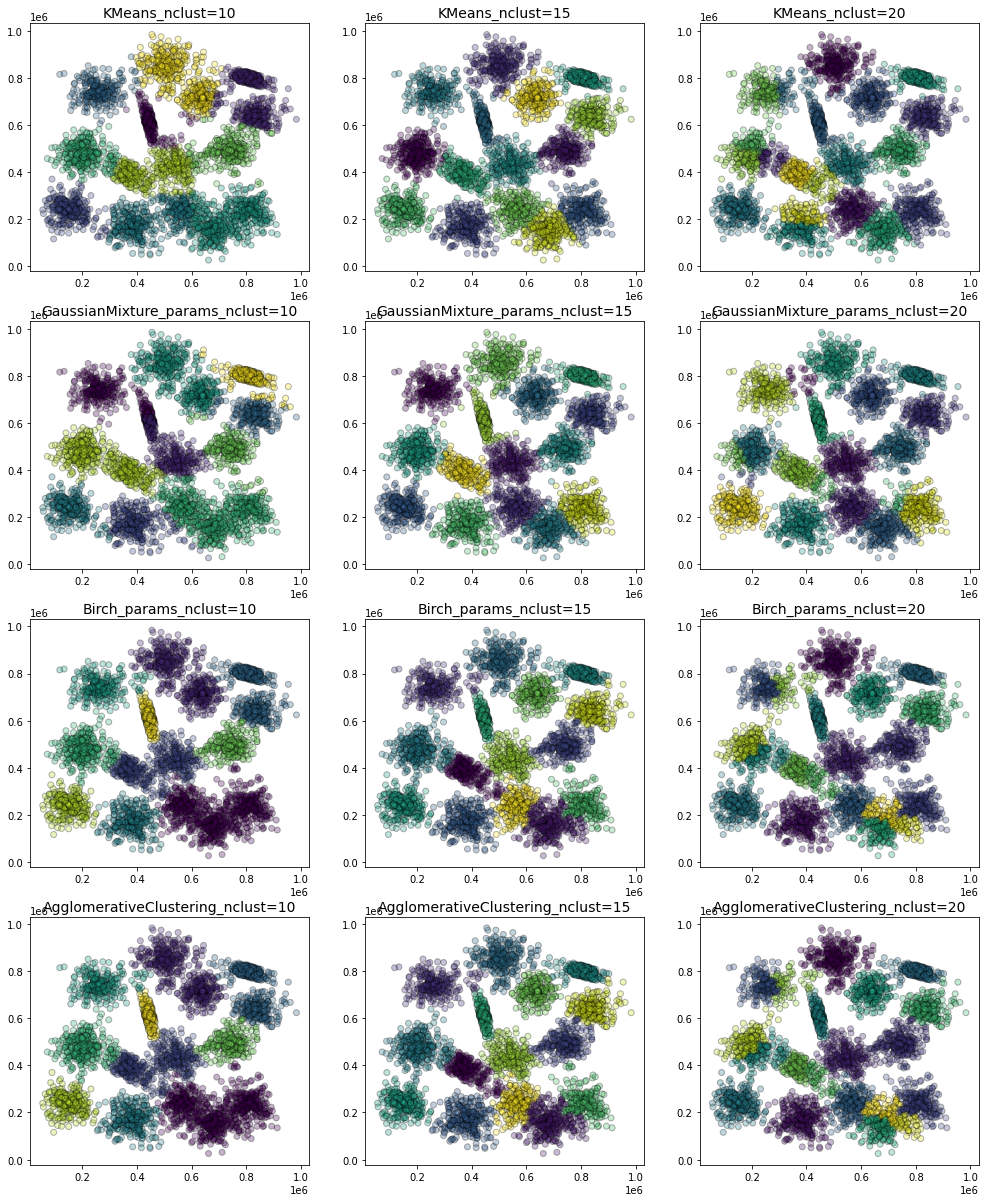

In [21]:
## BEGIN SOLUTION (do not delete this comment!)
def plot_clustering(methods, plot_only=[10, 15, 20]):
    fig, axs = plt.subplots(4, len(plot_only), figsize=(17, 21))
    i = 0
    for k in methods.keys():
        if int(k.split('=')[-1]) in plot_only:
            ax = axs.ravel()[i]
            pred_labels = methods[k].fit_predict(points)
            ax.scatter(points[:,0], points[:,1], c=pred_labels, alpha=0.3, edgecolor='k')
            ax.set_title(k, fontsize=14)
            i += 1
        else:
            continue

plot_clustering(bst_clust_methods)
### END SOLUTION (do not delete this comment!)

2) For each number of clusters vizualize the clustering result, calculate the clustering metrics and plot them;


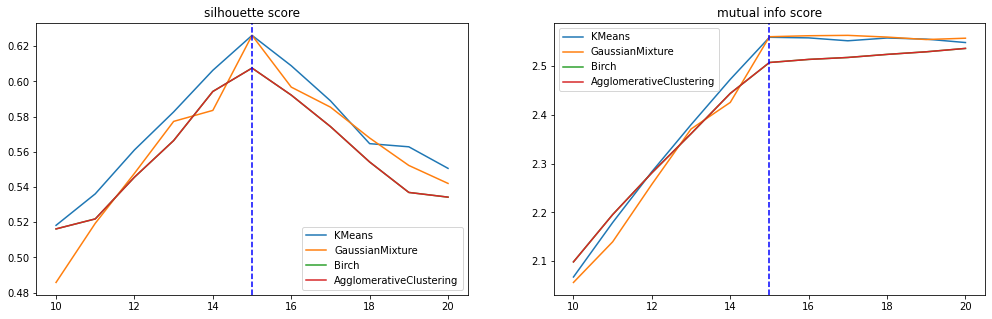

In [22]:
### BEGIN SOLUTION (do not delete this comment!)

fig, axs = plt.subplots(1, 2, figsize=(17, 5))
silh_scores = {}
mi_scores = {}
n_clusters = []

for method_name in bst_clust_methods.keys():
    name = method_name.split('_')[0]
    if name not in silh_scores.keys():
        silh_scores[name] = []
    if name not in mi_scores.keys():
        mi_scores[name] = []
    
    clust_n = method_name.split('=')[-1]
    if int(clust_n) not in n_clusters:
        n_clusters.append(int(clust_n))
    pred = bst_clust_methods[method_name].fit_predict(points)
    silh_scores[name].append(silhouette_score(points, pred))
    mi_scores[name].append(mutual_info_score(labels, pred))

for name in silh_scores.keys():
    axs[0].plot(n_clusters, np.array(silh_scores[name]), label=name)
    axs[1].plot(n_clusters, np.array(mi_scores[name]), label=name)
    
axs[0].axvline(x=true_number_of_clusters, color='b', ls='--')
axs[1].axvline(x=true_number_of_clusters, color='b', ls='--')
axs[0].set_title('silhouette score')
axs[1].set_title('mutual info score')
axs[0].legend()
axs[1].legend()
        

### END SOLUTION (do not delete this comment!)

### Task 3.2. Finding the Number of Clusters with Bootstrap. (1 pt.)
For a chosen algorithm find the best number of clusters using bootstrap. Based on your observations made at the previous task, choose one algorithm assuming **you do not have true labels and do not know the true number of clusters**.
1. Estimate variance of the clustering metric of your choice (i.e. *silhouette score*/*mutual information*/*adjusted mutual information*)and construct normal 95% **confidence interval (CI)**;
2. **Plot the metric** with the corresponding confidence intervals and show the best number of clusters.

__Hints:__ 
- you can choose bootstrap samples with any size, and sample number starting from `50`;
- you can use `scipy.stats.norm.interval()` to derive CI;

1) Estimate variance of the clustering metric of your choice (i.e. silhouette score/mutual information/adjusted mutual information)and construct normal 95% confidence interval (CI);

In [23]:
### BEGIN SOLUTION (do not delete this comment!)
rnd_state = 42
rng = np.random.RandomState(rnd_state)
method = KMeans
n_iters = 100
num_clust = np.arange(10, 20+1)
nclusters_scores = []
for n in num_clust:
    scores = []
    print(f'Method KMeans n_clusters={n}')
    # bootstrap
    for i in tqdm_notebook(range(n_iters)):
        points_new = points[rng.randint(0, points.shape[0], size=points.shape[0])]

        # fit clustering method and predict labels
        clf = method(n_clusters=n, random_state=rnd_state)
        labels_pred = clf.fit_predict(points_new)
        scores.append(silhouette_score(points_new, labels_pred))
        
    nclusters_scores.append(scores)
    
nclusters_scores = np.array(nclusters_scores)   
 
### END SOLUTION (do not delete this comment!)

Method KMeans n_clusters=10



Method KMeans n_clusters=11



Method KMeans n_clusters=12



Method KMeans n_clusters=13



Method KMeans n_clusters=14



Method KMeans n_clusters=15



Method KMeans n_clusters=16



Method KMeans n_clusters=17



Method KMeans n_clusters=18



Method KMeans n_clusters=19



Method KMeans n_clusters=20


2) Plot the metric with the corresponding confidence intervals and show the best number of clusters.

Number of clusters: 10
	Variance: 3.4370174110918694e-05
	Confidence interval: (0.5065191500210983, 0.5295001516099919)

Number of clusters: 11
	Variance: 4.895830337202237e-05
	Confidence interval: (0.5234906663878592, 0.5509184848453798)

Number of clusters: 12
	Variance: 3.56981853969518e-05
	Confidence interval: (0.5490459011470281, 0.5724666704918548)

Number of clusters: 13
	Variance: 2.32289050940674e-05
	Confidence interval: (0.5742496767554104, 0.5931423083739724)

Number of clusters: 14
	Variance: 2.0180442298185165e-05
	Confidence interval: (0.6041903891890906, 0.6217997433023875)

Number of clusters: 15
	Variance: 1.51582837865521e-05
	Confidence interval: (0.6191661909641454, 0.6344278976784595)

Number of clusters: 16
	Variance: 2.4774874029114905e-05
	Confidence interval: (0.6010007123158895, 0.6205119048341062)

Number of clusters: 17
	Variance: 4.504648375921628e-05
	Confidence interval: (0.5807700702521178, 0.6070793243181757)

Number of clusters: 18
	Variance: 8.3646

ValueError: x and y must have same first dimension, but have shapes (10,) and (11,)

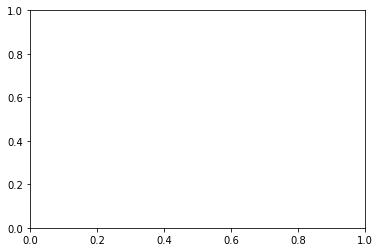

In [24]:
### BEGIN SOLUTION (do not delete this comment!)
intervals = []
for i, scores in enumerate(nclusters_scores):
    print('Number of clusters:', num_clust[i])
    # show variance and confidence interval
    print(f'\tVariance: {scipy.stats.norm.var(loc=np.mean(scores), scale=np.std(scores))}')
    intervals.append(scipy.stats.norm.interval(.95, loc=np.mean(scores), scale=np.std(scores)))
    print(f'\tConfidence interval: {intervals[-1]}')
    print()
    
    
plt.plot(np.arange(10, 20), np.mean(nclusters_scores, axis = 1), c = 'blue')
plt.axvline(x=true_number_of_clusters, color='black', ls='--')
plt.fill_between(np.arange(10, 20), np.array(intervals)[:, 0], np.array(intervals)[:, 1], alpha = 0.3)
plt.title(f" Mean silhouette score and it's 95% confidence interval")
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')

### END SOLUTION (do not delete this comment!)

Expected output format

Number of clusters: 10
	 Variance: 0.00011655090890401184
	 Confidence interval: (0.4981898828604859, 0.5405089337510356)

Number of clusters: 11
	 Variance: 9.78174625176354e-05
	 Confidence interval: (0.5193713712055965, 0.5581405215293416)

Number of clusters: 12
	 Variance: 4.72606550310619e-05
	 Confidence interval: (0.5470124857580626, 0.5739605736413137)

Number of clusters: 13
	 Variance: 6.169181893391729e-05
	 Confidence interval: (0.5718514349177481, 0.6026401719498748)

Number of clusters: 14
	 Variance: 3.944696446653126e-05
	 Confidence interval: (0.5994452202332297, 0.6240650406712072)

Number of clusters: 15
	 Variance: 4.367441896189854e-05
	 Confidence interval: (0.6129999980556734, 0.6389054787082208)

Number of clusters: 16
	 Variance: 4.446544304189413e-05
	 Confidence interval: (0.6001565711100141, 0.6262955969824031)

Number of clusters: 17
	 Variance: 6.241709905832504e-05
	 Confidence interval: (0.5823868208517342, 0.6133560130103775)

N

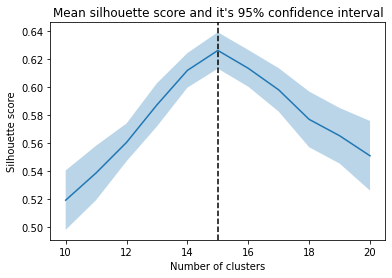

In [ ]:
### BEGIN SOLUTION (do not delete this comment!)


### END SOLUTION (do not delete this comment!)

## Task 4. Practice with Different Anomaly Detection Algorithms. (2 pts)

### Task 4.1 (1 pt)

- Here we will use __fraud_dataset__ (creditcard.csv )
- Compute the __contamination__ (or impurity) on the **test** set as the ratio of anomaly objects to all the objects.  
- Predict the anomaly with any **three** Anomaly detection methods among ones from: https://scikit-learn.org/stable/modules/outlier_detection.html, note, we do not use true labels to fit anomaly detectors.
- Explore, how the `roc_auc_score` for anomaly detectors changes with `contamination` value, taking a grid `[0.1*contamination, 1*contamination, 10*contamination]`. Point out the best performing algorithm.

In [261]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score

data = pd.read_csv('creditcard.csv')

X = data.drop(columns="Class")
y = data["Class"]

# keep the split fixed
tt_split = train_test_split(X, y, test_size = 0.1, stratify=y, random_state= 42)
train_X, test_X, train_y, test_y = tt_split 

# delete the targets for training
train_y = 0

In [268]:
### BEGIN SOLUTION (do not delete this comment!)
  
# impurity estimation on test data
impurity = sum(test_y[test_y == 1]) / len(test_y)
print(f'Impurity: {impurity}')

### END SOLUTION (do not delete this comment!)

Impurity: 0.01693743518838576


In [372]:
### BEGIN SOLUTION (do not delete this comment!)

# Choose three anomaly detection models

anomaly_detection_methods = {'IsolationForest': {'method': IsolationForest,
                                                 'params': {'n_estimators': 100}},
                             'OneClassSVM': {'method': OneClassSVM, 
                                             'params': {'kernel': 'rbf'}},
                             'LocalOutlierFactor': {'method': LocalOutlierFactor,
                                                    'params': {'n_neighbors': 20,
                                                               'novelty': True}}}

for i in [0.1, 1, 10]:
    # >>> your solution here <<<
    for k in anomaly_detection_methods.keys():
        params = anomaly_detection_methods[k]['params']
        if 'SVM' in k:
            params['nu'] = impurity*i
        else:
            params['contamination'] = impurity*i
            
        fitted_method = anomaly_detection_methods[k]['method'](**params).fit(test_X)
        y_pred = (1 - fitted_method.predict(test_X))/2   

        print(f'{k}: Contamination: {impurity*i:.3f}   ROC/AUC:  {roc_auc_score(test_y, y_pred):.3f} Precision: {precision_score(test_y, y_pred, average=None)[0]:.3f}')
    print()
    
# IsolationForest has best ROC/AUC scores

### END SOLUTION (do not delete this comment!)

IsolationForest: Contamination: 0.002   ROC/AUC:  0.551 Precision: 0.985
OneClassSVM: Contamination: 0.002   ROC/AUC:  0.499 Precision: 0.983
LocalOutlierFactor: Contamination: 0.002   ROC/AUC:  0.499 Precision: 0.983

IsolationForest: Contamination: 0.017   ROC/AUC:  0.730 Precision: 0.991
OneClassSVM: Contamination: 0.017   ROC/AUC:  0.491 Precision: 0.983
LocalOutlierFactor: Contamination: 0.017   ROC/AUC:  0.513 Precision: 0.984

IsolationForest: Contamination: 0.169   ROC/AUC:  0.850 Precision: 0.997
OneClassSVM: Contamination: 0.169   ROC/AUC:  0.539 Precision: 0.985
LocalOutlierFactor: Contamination: 0.169   ROC/AUC:  0.476 Precision: 0.982



### Task 4.2 (1 pt)

The idea is to see when anomaly detection methods, trained with no labels, can facilitate the prediction of the classifier. Imagine a real case scenario: you have labelled only a small portion of the dataset and a bunch of unlabeled data. We will simulate the situation when __90%__ of data is unlabeled and we still desire to achieve good performance. 


As you can score your predictions only on the __10%__ of the sample, you better do it in cross validation to ensure the model stability.
1. Take your favorite classifier and estimate the performance on __test set__ using `StratifiedKFold(n_splits=10, random_state = 42)` with `roc_auc` and `precision_score`. You can use test set upsampling and other instruments to enforce your prediction. 

> Do not get confused, here we swap __train__ and __test__ and use __test__ as if it's the only data we have on our hands.

2. Try to enhance the classifier performance in  `roc_auc` or `precision_score` (or ideally both), building the ensemble, using __Anomaly detection__ methods from the previous task. You can fit __Anomaly detection__ methods on both  __training set__ and subset from __test set__ on the cross-validation fold.

__NOTE:__ try not to overfit, thus not adjust the `contamination` while training, and refit classifiers on each fold. 

__Hints:__ `sklearn.ensemble.VotingClassifier` does not support Anomaly detection methods, so you are to write it yourself. And `np.logical_and` or `np.logical_or` will suit for the trivial ensemble.

In [327]:
### BEGIN SOLUTION (do not delete this comment!)

# choose your favorite classifier, e.g. from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=10, random_state = 42, shuffle=True)
skf.get_n_splits(test_X, test_y)

roc_auc_scores = [] 
pr_score = []

clf = AdaBoostClassifier(n_estimators=100, random_state = 42)

rng = np.random.RandomState(rnd_state)
rng.randint(0, points.shape[0], size=points.shape[0])

for train_index, test_index in skf.split(test_X, test_y):
    # >>> your solution here <<<
    X_train, X_test = test_X.iloc[train_index], test_X.iloc[test_index]
    y_train, y_test = test_y.iloc[train_index],  test_y.iloc[test_index]
    
    X_train_pos, X_train_neg = X_train[y_train == 1], X_train[y_train == 0]
    y_train_pos, y_train_neg = y_train[y_train == 1], y_train[y_train == 0]
    pos_idxs = rng.randint(0, len(y_train[y_train == 1]), size=X_train.shape[0])
    neg_idxs = rng.randint(0, len(y_train[y_train == 0]), size=X_train.shape[0])
    
    X_train_boot = pd.concat([X_train, X_train_pos.iloc[pos_idxs]])
    y_train_boot = pd.concat([y_train, y_train_pos.iloc[pos_idxs]])
    
    clf.fit(X_train_boot, y_train_boot)
    y_pred = clf.predict(X_test)
    roc_auc_scores.append(roc_auc_score(y_test, y_pred))
    pr_score.append(precision_score(y_test, y_pred, average=None)[0])
  

print(f'ROC/AUC mean {np.mean(roc_auc_scores)}  std:  {np.std(roc_auc_scores)}')
print(f'Precision mean {np.mean(pr_score)}  std:  {np.std(pr_score)}')

### END SOLUTION (do not delete this comment!)

ROC/AUC mean 0.9392970101309613  std:  0.06623202774012907
Precision mean 0.9978971818890277  std:  0.0023222949425510094


Try to enhance the classifier performance using Anomaly detection methods

In [373]:
### BEGIN SOLUTION (do not delete this comment!)

skf = StratifiedKFold(n_splits=10, random_state = 42, shuffle=True)
skf.get_n_splits(test_X, test_y)

roc_auc_scores = [] 
pr_score = []

anomaly_detection_methods = {'IsolationForest': {'method': IsolationForest,
                                                 'params': {'n_estimators': 100, 'random_state': 42}},
                             'OneClassSVM': {'method': OneClassSVM, 
                                             'params': {'kernel': 'rbf'}},
                             'LocalOutlierFactor': {'method': LocalOutlierFactor,
                                                    'params': {'n_neighbors': 20,
                                                               'novelty': True}}}

for train_index, test_index in skf.split(test_X, test_y):
    # >>> your solution here <<<
    X_train, X_test = test_X.iloc[train_index], test_X.iloc[test_index]
    y_train, y_test = test_y.iloc[train_index],  test_y.iloc[test_index]
    y_preds = []
    for k in anomaly_detection_methods.keys():
        params = anomaly_detection_methods[k]['params']
        if 'SVM' in k:
            params['nu'] = impurity
        else:
            params['contamination'] = impurity
            
        all_train = pd.concat([train_X, X_train])
        fitted_method = anomaly_detection_methods[k]['method'](**params).fit(all_train)
        y_preds.append((1 - fitted_method.predict(X_test))/2)  

    # logical or
#     y_pred_final = sum(y_preds)
#     y_pred_final[y_pred_final > 1] = 1
    # max voting
    y_preds[0] *= 2
    y_preds[1] *= 1/2

    y_pred_final = np.mean(y_preds, axis=0)
    y_pred_final[y_pred_final >= 0.3] = 1
    y_pred_final[y_pred_final < 0.3] = 0
    roc_auc_scores.append(roc_auc_score(y_test, y_pred_final, average=None))
    pr_score.append(precision_score(y_test, y_pred_final, average=None)[0])
    
print(f'ROC/AUC mean {np.mean(roc_auc_scores)}  std:  {np.std(roc_auc_scores)}')
print(f'Precision mean {np.mean(pr_score)}  std:  {np.std(pr_score)}')

### END SOLUTION (do not delete this comment!)

ROC/AUC mean 0.7401723498888065  std:  0.10025131117897225
Precision mean 0.9916032349280914  std:  0.0032696645602938307


Write 1-2 sentences on your findings.

*BEGIN SOLUTION (do not delete this comment!)*

Regarding ensembling of anomaly detection methods -- logical_and and logical_or approaches didn't work well and the results were significantly worse comparing to classifier. For voting strategy the precision got close to the values of the classifier, but roc/auc score was still quite low. To improve this I added more weights to the best classifier from the set (Forest) and add lower weight to to bad classifiers (SVM). This helped to improve both roc/auc and precision, however they are still worse than the AdaBoost classifier results. Maybe a more sophisticated ensembling strategy should be applied. 

*END SOLUTION (do not delete this comment!)*